# Supervised Learning Project
## Room Occupancy Detection
Ana André, data squad #21

## Table of Contents

- [Context](#context)
- [Motivation](#motivation)
- [Dataset](#dataset)
- [Explore the dataset](#explore-dataset)
- [Modeling, prediction and evaluation - Original Data Set](#modeling-original-dataset)
- [Modeling, prediction and evaluation - Resampling the data](#modeling-resampled-dataset)
- [Recursive feature elimination](#RFE)
- [Cross validation](#CV)

<a name="context"></a>

## Context

For this project I put myself on the shoes of a data analyst working for a building facilities management company and I did a supervised machine learning for room occupancy detection to improve the algorithm of the HVAC control systems.

<a name="motivation"></a>

## Motivation

Energy efficiency in buildings has been a hot topic for quite a while now both for sustainability and cost reasons.
Literature states that the accurate determination of room occupancy detection can lead to energy savings up to 30 to 40 % which can mean a lot in terms of money and CO2 emitions.
So designing smart buildings, buildings able to adjust to user's needs in real time, is the path we want to follow.

<a name="dataset"></a>

## Dataset

I got my dataset from the University of California's repository for machine learning.
It results from an experiment that monotorized 4 environmental measures over time:
- temperature
- humidity
- light
- CO2 concentration.
20560 instances for each feature.
There is also a label feature to specify the room occupation (1 for occupied, 0 for non-occupied)

[Dataset](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#)

<a name="explore-data"></a>


## Explore the data

### Import libraries

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%config InlineBackend.figure_format='retina'

### Load the data

In [4]:
# load the data
dataset1 = pd.read_csv('../data/dataset1.csv')#, index_col = 0) # testing, door mostly closed
dataset2 = pd.read_csv('../data/dataset2.csv')#, index_col = 0) # testing, door mostly open
dataset3 = pd.read_csv('../data/dataset3.csv')#, index_col = 0) # training

In [5]:
# datasets shape
print("dataset 1 shape is :", dataset1.shape)
print("dataset 2 shape is :", dataset2.shape)
print("dataset 3 shape is :", dataset3.shape)

dataset 1 shape is : (2665, 7)
dataset 2 shape is : (9752, 7)
dataset 3 shape is : (8143, 7)


In [6]:
dataset1.head(2)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.700,26.272,585.2,749.2,0.004764,1
1,2015-02-02 14:19:00,23.718,26.290,578.4,760.4,0.004773,1


Data is provided with:
- date-time information
- records for 6 environmental measures taken each minute over multiple days

Measures units:
- Temperature in Celsius
- Relative humidity as a percentage
- Light measured in lux
- Carbon dioxide measured in parts per million
- Humidity ratio, derived from temperature and relative humidity measured in kilograms of water vapor per kilogram of air
- Occupancy as either 1 for occupied or 0 for not occupied

### Overview of the data over time

In [8]:
# load the data for time series
d1_ts = pd.read_csv('../data/dataset1.csv', index_col = 0) # testing, door mostly closed
d2_ts = pd.read_csv('../data/dataset2.csv', index_col = 0) # testing, door mostly open
d3_ts = pd.read_csv('../data/dataset3.csv', index_col = 0) # training

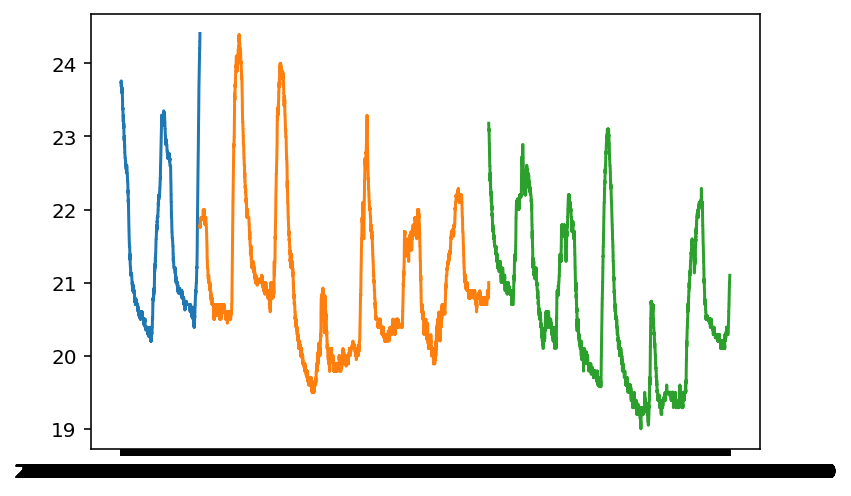

In [9]:
# plot temperature over time
plt.plot(d1_ts['Temperature'])
plt.plot(d2_ts['Temperature'])
plt.plot(d3_ts['Temperature'])
plt.show()

The datasets don't overlap but there are some gaps.

### Concatenate the datasets

I decided to just add the 3 datasets together and use all that information for train and test.
I kept the temporal consistency of the data.

In [10]:
#concatenate the datasets
datasets = [dataset1, dataset2, dataset3]

data = pd.concat(datasets)

In [11]:
# overview of the firts 5 rows
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:00,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [12]:
# check the dataset shape
data.shape

(20560, 7)

In [13]:
data.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [14]:
# check for duplicates on date column
data.date.duplicated().sum()

4114

In [15]:
# check the duplicated rows on date column
data[data.date.duplicated()][:10]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-02 14:19:00,23.718,26.2900,578.400000,760.400000,0.004773,1
5,2015-02-02 14:23:00,23.760,26.2600,568.666667,790.000000,0.004779,1
7,2015-02-02 14:25:00,23.754,26.2900,509.000000,797.000000,0.004783,1
13,2015-02-02 14:31:00,23.700,26.7000,469.000000,845.333333,0.004842,1
20,2015-02-02 14:38:00,23.640,27.1000,473.000000,908.800000,0.004898,1
26,2015-02-02 14:44:00,23.625,27.3925,498.666667,961.000000,0.004946,1
33,2015-02-02 14:51:00,23.600,27.5400,512.000000,992.600000,0.004966,1
37,2015-02-02 14:55:00,23.600,27.7000,483.166667,1009.500000,0.004995,1
39,2015-02-02 14:57:00,23.600,27.7900,473.000000,1021.000000,0.005011,1
46,2015-02-02 15:04:00,23.500,27.9780,454.000000,1055.250000,0.005015,1


In [16]:
#check data types
data.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [17]:
# convert date column to date data type
data['date'] = pd.to_datetime(data['date'])
data.dtypes

date             datetime64[ns]
Temperature             float64
Humidity                float64
Light                   float64
CO2                     float64
HumidityRatio           float64
Occupancy                 int64
dtype: object

In [18]:
type(data['date'][0])

pandas.core.series.Series

In [19]:
# sort the dataset by the date column values
data_sorted = data.sort_values(by='date')
data_sorted.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:00,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [20]:
# reset index
data_idx = data_sorted.reset_index(drop=True)

In [21]:
# check the index
data_idx.index

RangeIndex(start=0, stop=20560, step=1)

In [23]:
# save the final dataset to csv
data_idx.to_csv('concatenated.csv')

In [23]:
# general overview of the features
data_idx.groupby('Occupancy').mean()

,Temperature,Humidity,Light,CO2,HumidityRatio
Occupancy,,,,,
0,20.584830,27.529654,25.237893,604.996614,0.004120
1,21.975909,28.076209,481.967380,975.321870,0.004589


Observations:

- in average, the temperature when the room is occupied is 1.5ºC higher than
for non-occupied conditions

- in average, the humidity when the room is occupied is 0.5% higher than
for non-occupied conditions

- in average, the light when the room is occupied is around 19x higher than
for non-occupied conditions

- in average, the C02 concentration when the room is occupied is 1.6x higher
than for non-occupied conditions

### Imbalanced data?

In [28]:
# check value counts for each label
data_idx['Occupancy'].value_counts()

0    15810
1     4750
Name: Occupancy, dtype: int64

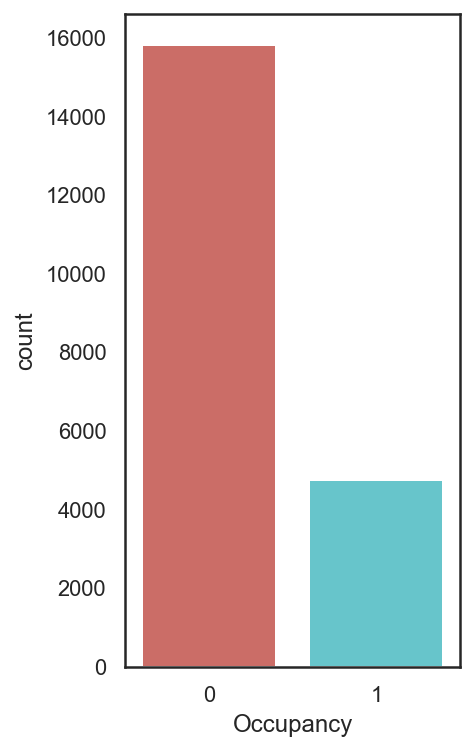

In [272]:
# plot labels histogram
f, ax = plt.subplots(figsize=(3,6))
sns.countplot(x= data_idx['Occupancy'], data=data_idx, palette='hls')
plt.show()

In [22]:
# check labels percentage
label_prop = (data_idx['Occupancy'].value_counts() / len(data['Occupancy'])) * 100
label_prop

0    76.896887
1    23.103113
Name: Occupancy, dtype: float64

The classes are imbalanced and the ration of non-occupied / occupied instances 
is 77:23
I have 50% more non-occupied than occupied instances.

### Fixing the data series

I tried to fix the data series but that was before I realize that I have long gaps because the measures were mainly monitorized over a day per month so fixing the data series had no point.

In [30]:
from datetime import datetime  
from datetime import timedelta  

dates = list(data_idx['date'][577:587])

In [31]:
dates

[Timestamp('2015-02-02 23:55:00'),
 Timestamp('2015-02-02 23:57:00'),
 Timestamp('2015-02-02 23:57:00'),
 Timestamp('2015-02-02 23:58:00'),
 Timestamp('2015-02-13 00:00:00'),
 Timestamp('2015-02-13 00:01:00'),
 Timestamp('2015-02-13 00:02:00'),
 Timestamp('2015-02-13 00:03:00'),
 Timestamp('2015-02-13 00:04:00'),
 Timestamp('2015-02-13 00:04:00')]

In [32]:
# fix the time series date column
for i in range(len(dates)-1):
    # calculate the difference between two dates
    delta = (dates[i+1] - dates[i]).total_seconds()
    #print(delta)
    if delta == 0: # case 1 - duplicates
        dates[i] = dates[i] # keeps the fisrt value
        dates[i+1] = dates[i] + timedelta(seconds=60) # add 1 minute to the following value
        #print('valor i-1:',dates[i-1])
        #print('valor i:',dates[i])
        
    elif delta > 60: # case 2 - gaps in the time series
        dates[i] = dates[i]
        times = int(delta / 60)
        for j in range(1,times):
            dates[i+j] = dates[i] + timedelta(seconds=60) * j
            dates.insert(i+j, dates[i+j]) # insert elem at index 0
            
    else: # case 3 - lag time equal or lower than 1 minute
        dates[i] = dates[i]
        dates[i+1] = dates[i+1]

In [ ]:
#dates

In [34]:
'''
2660   2015-04-02 10:38:00
2661   2015-04-02 10:40:00
2662   2015-04-02 10:40:00
2663   2015-04-02 10:41:00
2664   2015-04-02 10:43:00
2665   2015-11-02 14:48:00
Name: date, dtype: datetime64[ns]
'''

'\n2660   2015-04-02 10:38:00\n2661   2015-04-02 10:40:00\n2662   2015-04-02 10:40:00\n2663   2015-04-02 10:41:00\n2664   2015-04-02 10:43:00\n2665   2015-11-02 14:48:00\nName: date, dtype: datetime64[ns]\n'

In [35]:
days_measure = pd.DatetimeIndex(data_idx['date']).date

In [36]:
print(np.unique(days_measure))

[datetime.date(2015, 2, 2) datetime.date(2015, 2, 13)
 datetime.date(2015, 2, 14) datetime.date(2015, 2, 15)
 datetime.date(2015, 2, 16) datetime.date(2015, 2, 17)
 datetime.date(2015, 2, 18) datetime.date(2015, 3, 2)
 datetime.date(2015, 4, 2) datetime.date(2015, 5, 2)
 datetime.date(2015, 6, 2) datetime.date(2015, 7, 2)
 datetime.date(2015, 8, 2) datetime.date(2015, 9, 2)
 datetime.date(2015, 10, 2) datetime.date(2015, 11, 2)
 datetime.date(2015, 12, 2)]


After this, I gave up trying to fix the time series because I realized that the measures were made only on specific day, kind
of on a monthly basis.

### Evaluating Correlation

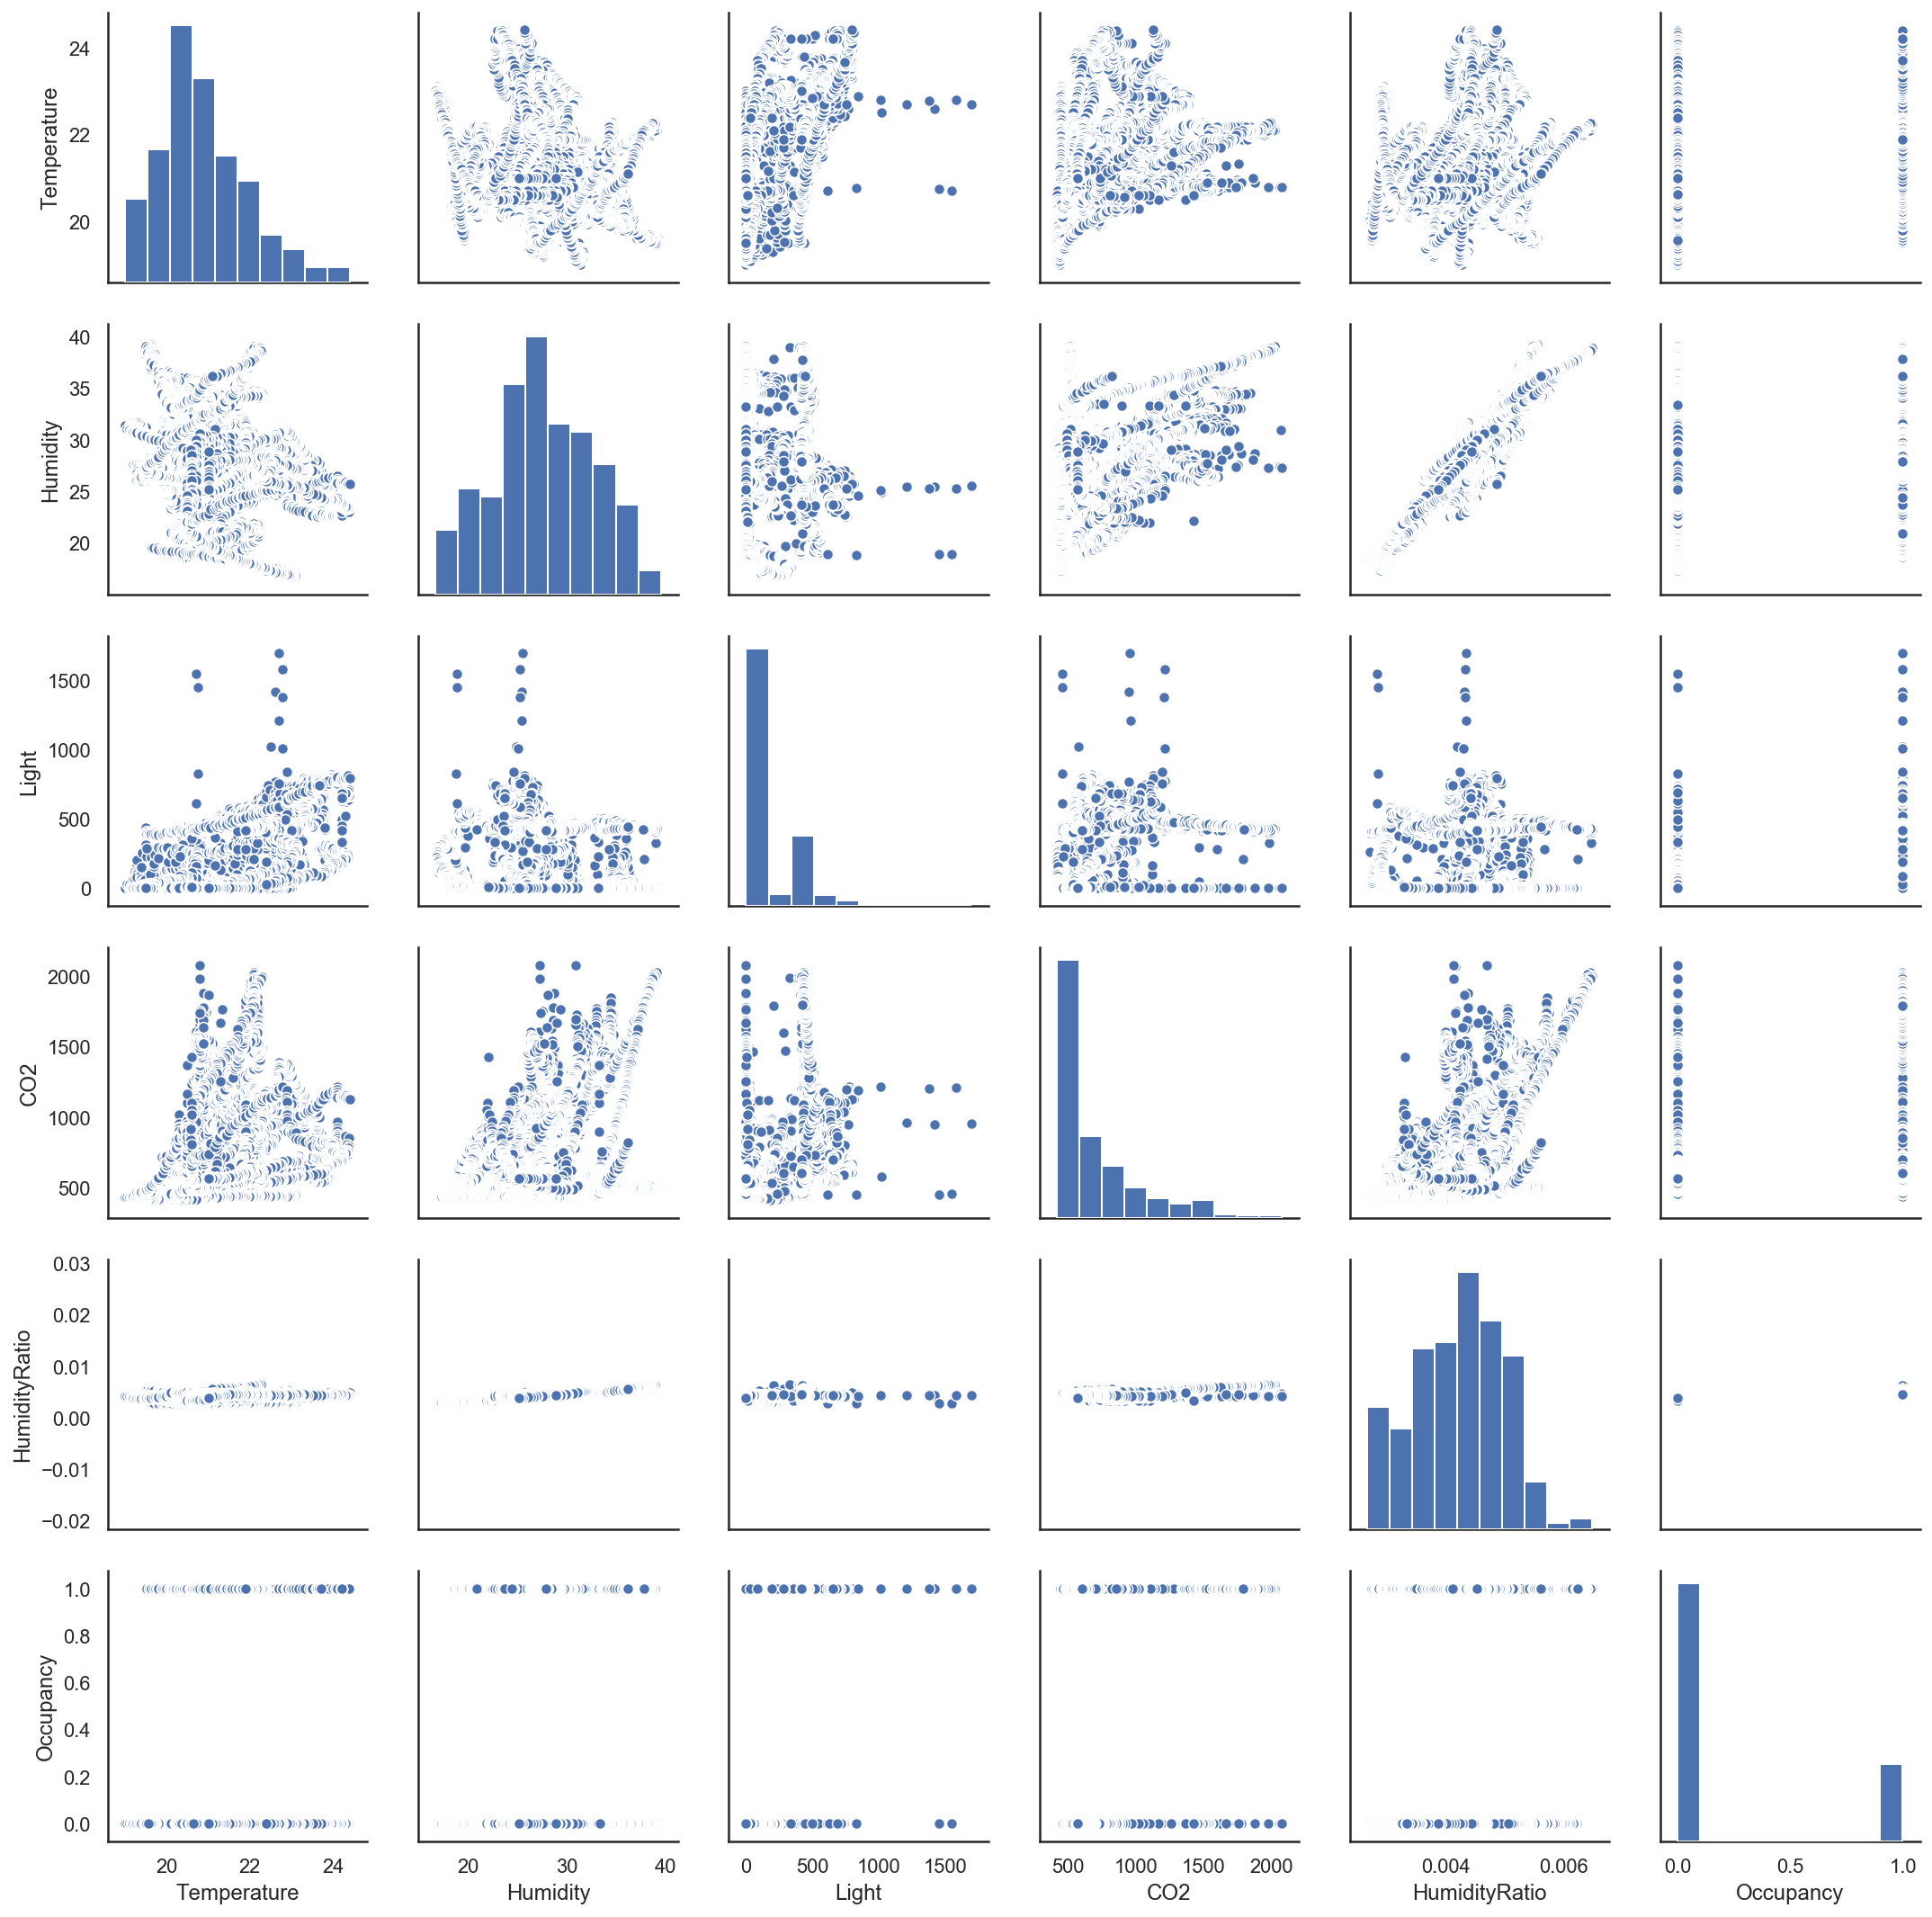

In [41]:
# for the total dataset
sns.pairplot(data_idx)

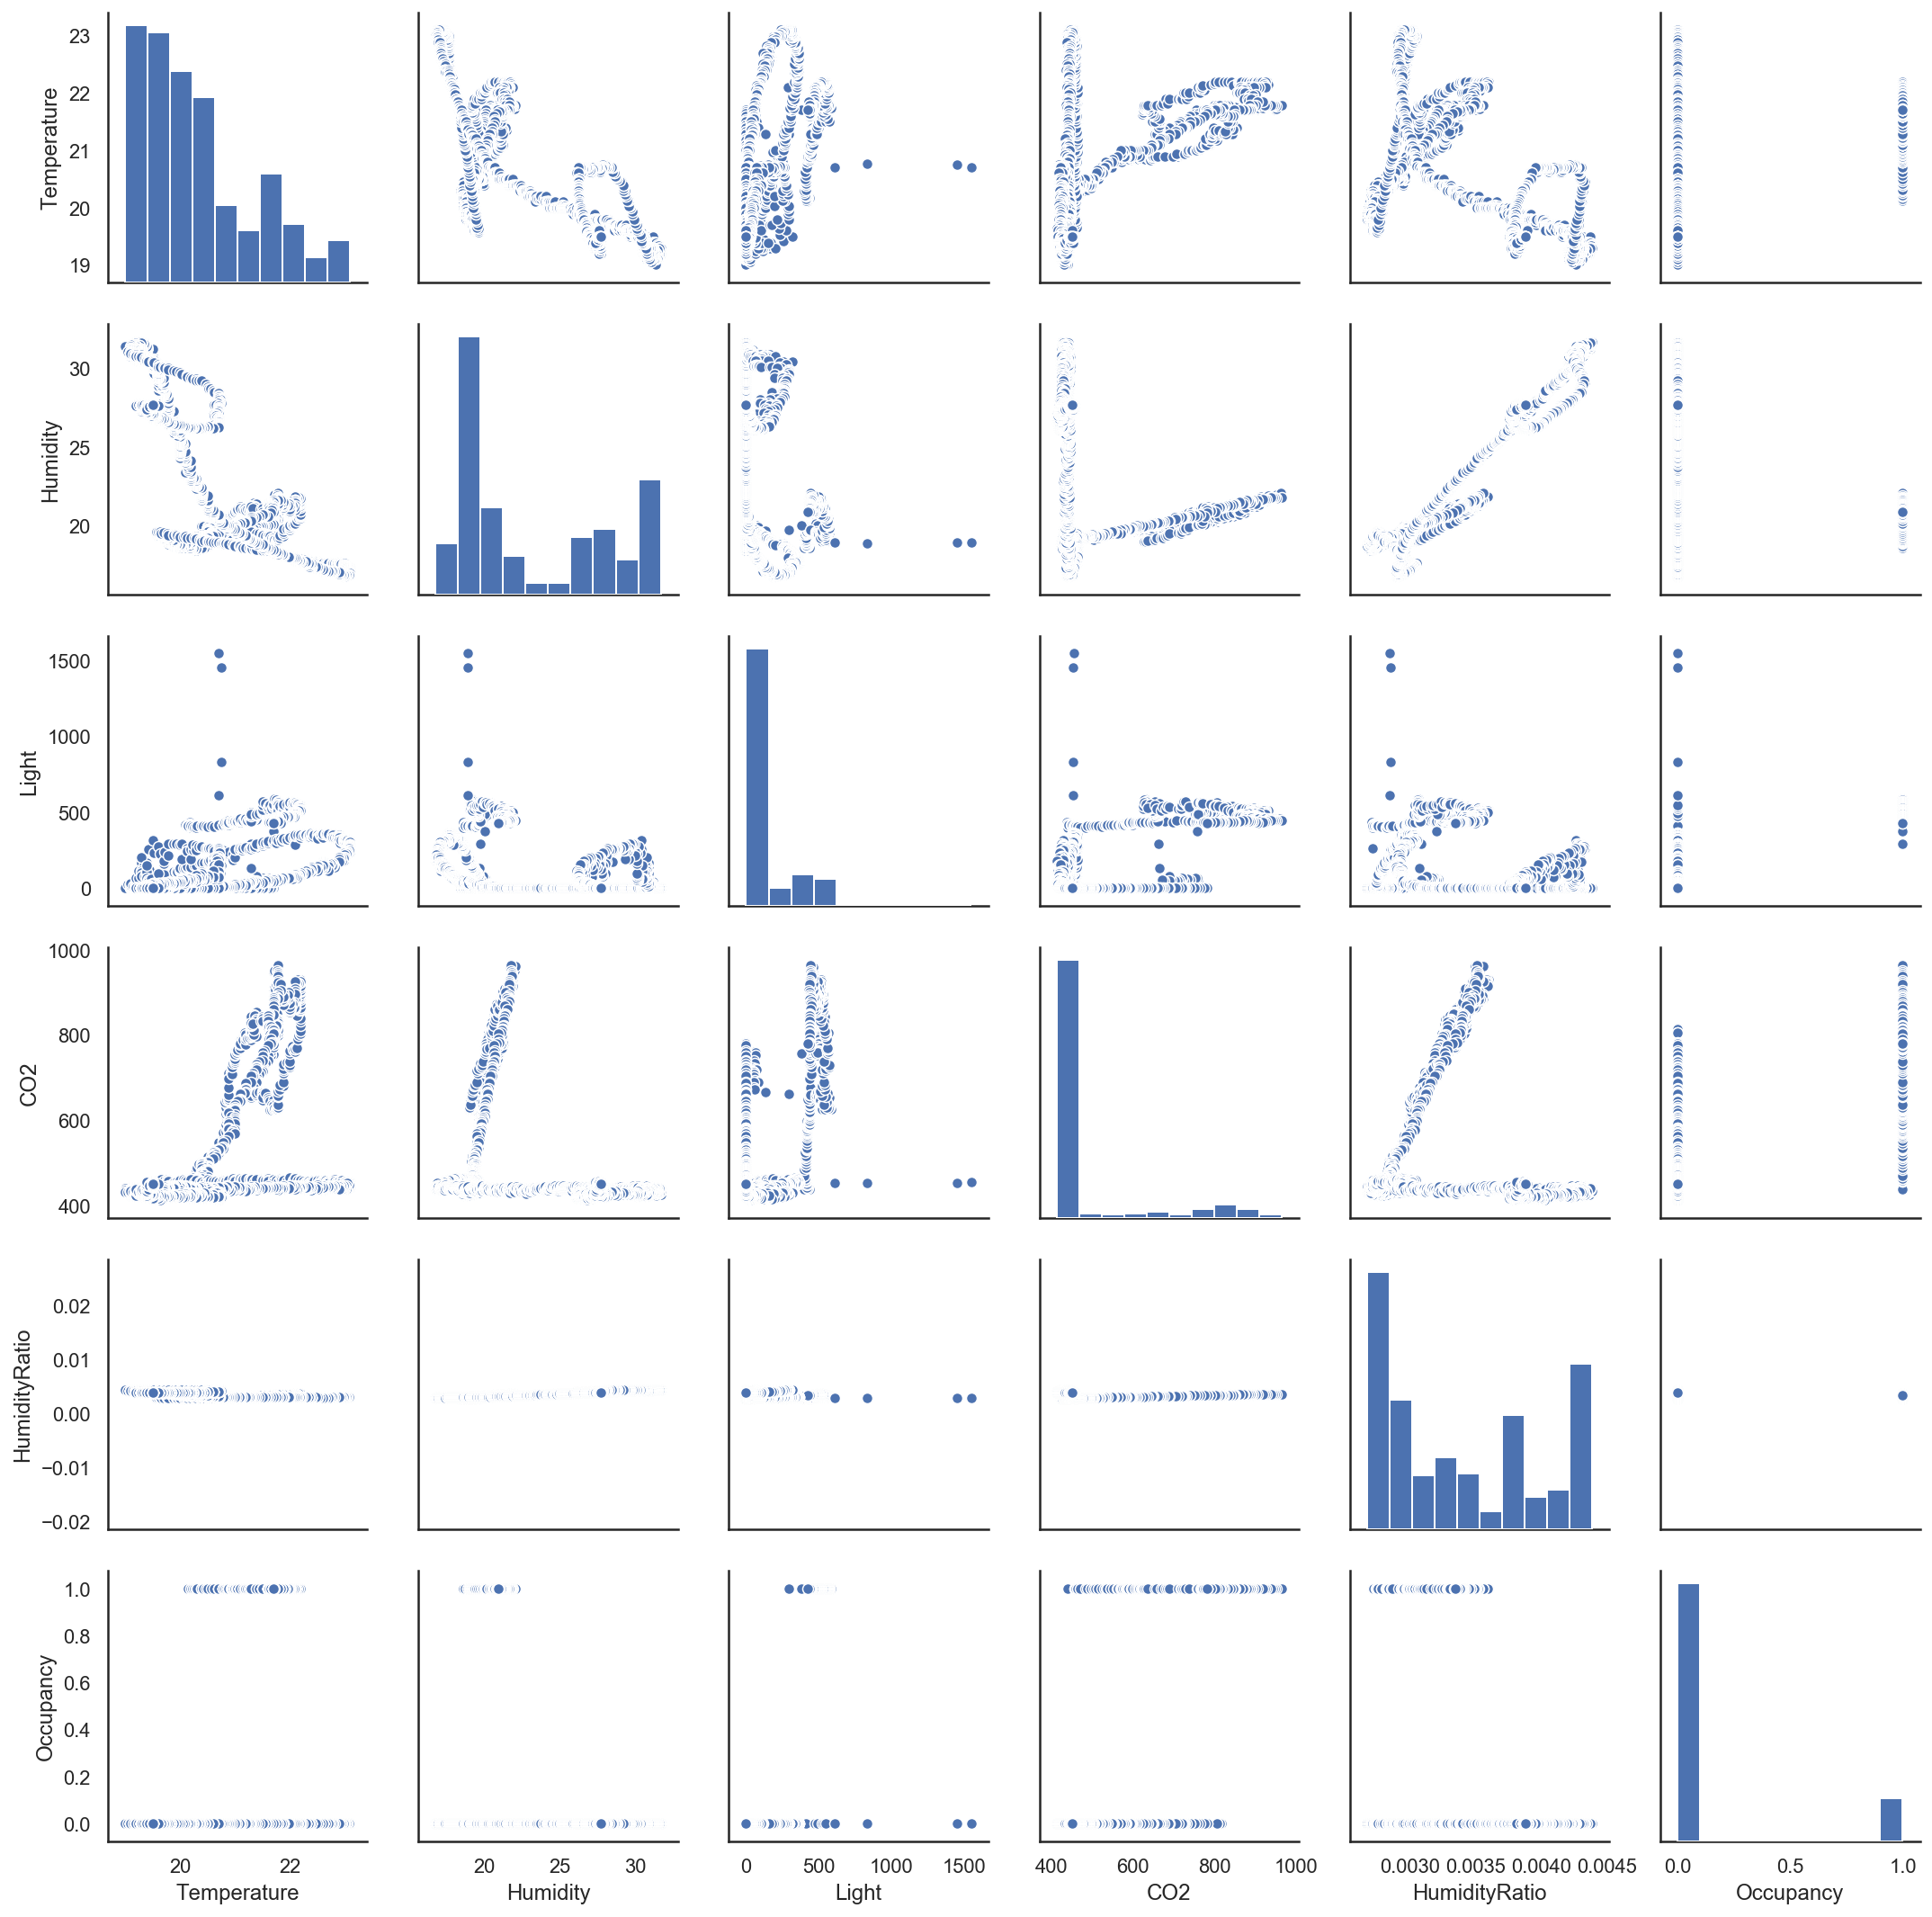

In [248]:
# for the fold were I got the worst score in the cross validation
sns.pairplot(data_idx[12336:16448])

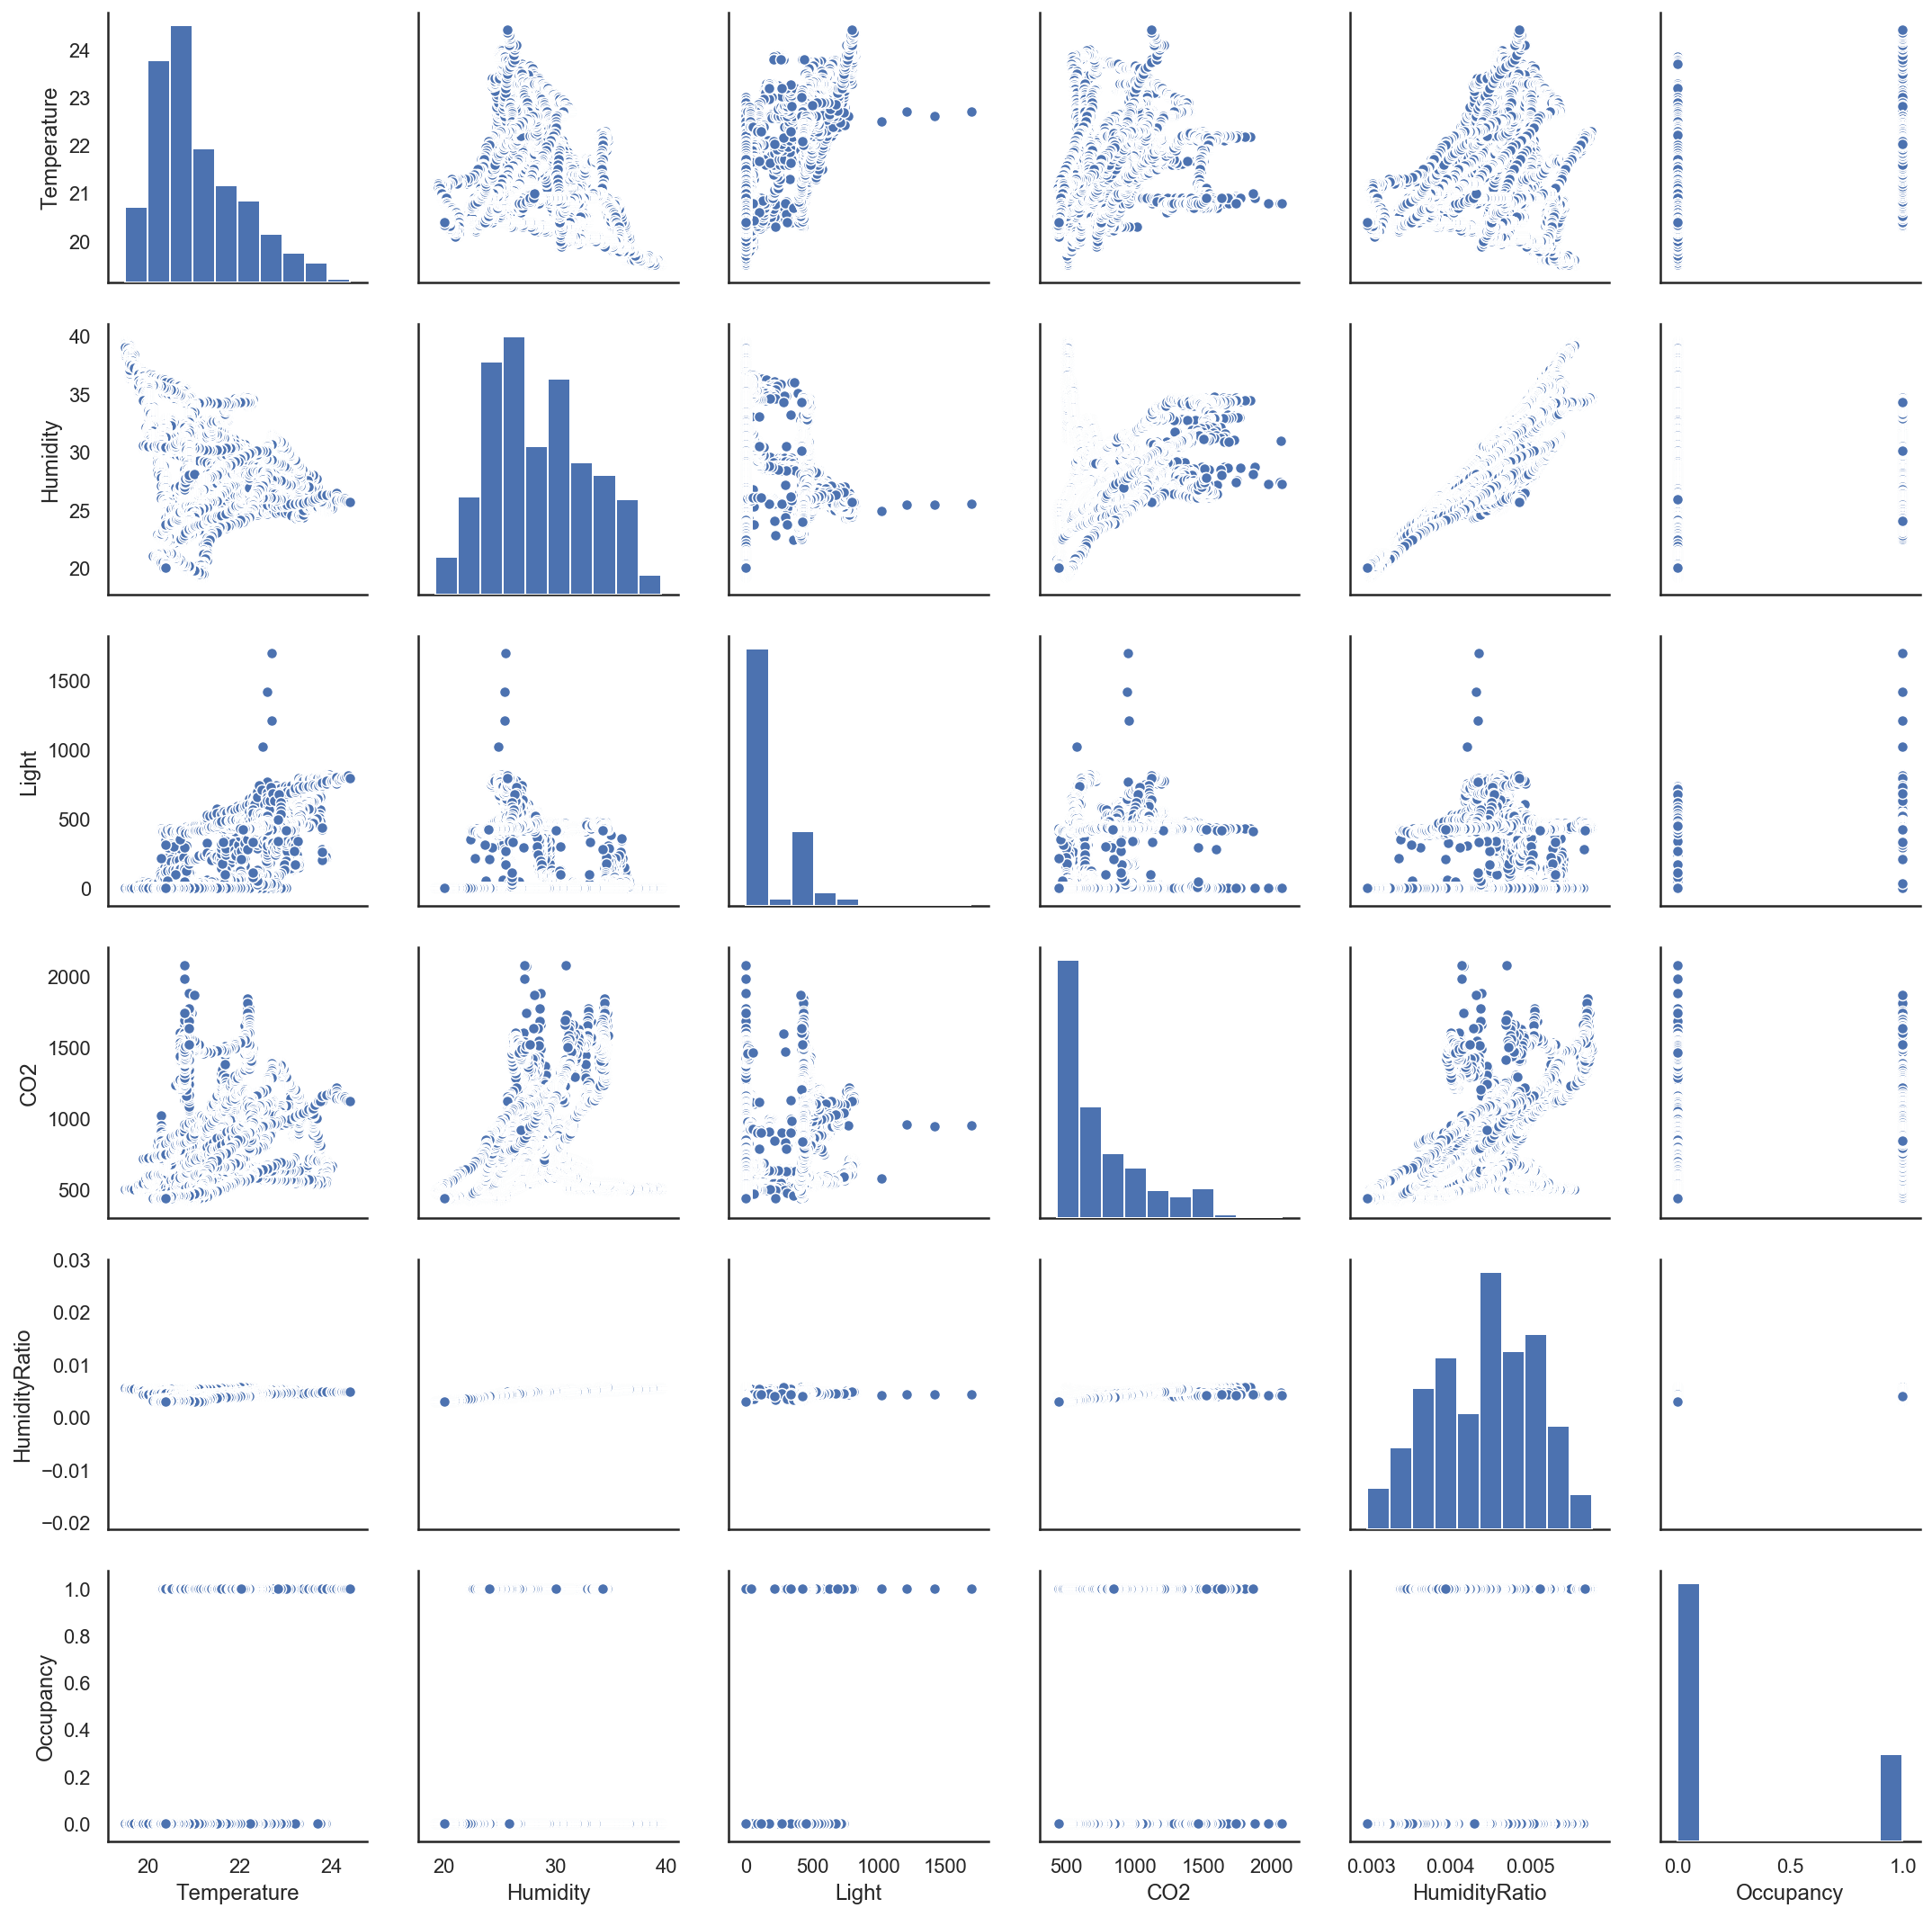

In [249]:
# for all the data up to row 12336
sns.pairplot(data_idx[:12336])

In [42]:
# calculate the correlation matrix
data_corr = data_idx.corr()
data_corr

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000000,-0.156964,0.688571,0.449989,0.205280,0.555610
Humidity,-0.156964,1.000000,-0.029459,0.299746,0.932724,0.046240
Light,0.688571,-0.029459,1.000000,0.448105,0.223329,0.914850
CO2,0.449989,0.299746,0.448105,1.000000,0.477965,0.501582
HumidityRatio,0.205280,0.932724,0.223329,0.477965,1.000000,0.257324
Occupancy,0.555610,0.046240,0.914850,0.501582,0.257324,1.000000


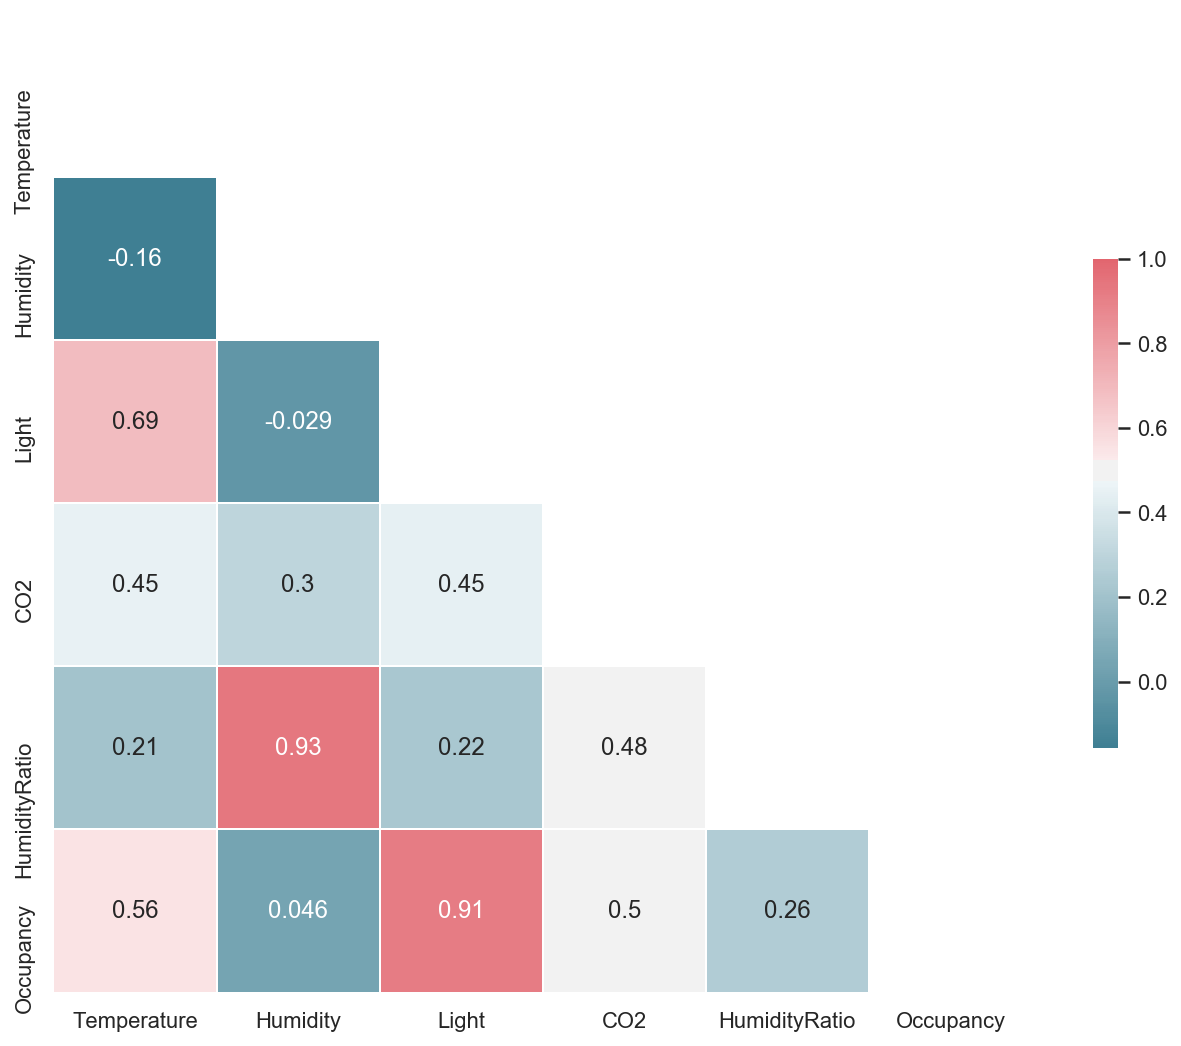

In [43]:
# create heatmap
sns.set(style="white")

# generate a mask for the upper triangle
mask = np.zeros_like(data_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap = True)

# draw the heatmap with the mask and correct aspect ration
sns.heatmap(data_corr, mask = mask, cmap = cmap, center = 0.5,
           annot = True, square = True, linewidths=.5, cbar_kws={'shrink':.5})
plt.show()

<a name="modeling-original-dataset"></a>

## Modeling, prediction and evaluation - Original Data Set

In [47]:
# split the data to train and test

# separate the dataframe into predictor and response variables
X = data_idx.drop(['Occupancy','date'], axis =1) # features
y = data_idx['Occupancy'] # target

# splitting the data to train and test
from sklearn.model_selection import train_test_split

training_prop = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = training_prop, random_state=29)

In [50]:
X.head(1)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.7,26.272,585.2,749.2,0.004764


I used 4 classification models:
- logistic regression
- decision tree
- support vector machine
- k-nearest neighbour

### 1. Logistic Regression

In [49]:
# load logistic regression
from sklearn.linear_model import LogisticRegression

# initialize the model
lr = LogisticRegression()

# fit the model to the training data
lr.fit(X_train, y_train)

C:\Nane\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
# accuracy score for training
acc_lr = lr.score(X_test, y_test) * 100 # do I need to calculate this score?

print(f"Logistic Regression Test Accuracy {round(acc_lr, 2)}%")

Logistic Regression Test Accuracy 98.93%


In [61]:
# predict the response for the test dataset
y_pred_lr = lr.predict(X_test)

In [62]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

confusion_matrix(y_test, y_pred_lr)

array([[3073,   40],
       [   4,  995]], dtype=int64)

Analyzing the results:
3073 + 995 correct predictions and 4 + 40 incorrect prediction

- C0,0 - the count of true negatives
- C1,0 - false negatives
- C1,1 - true positives
- C0,1 - false positives

In [65]:
# print accuracy_score for the testing
accuracy_score(y_test, y_pred_lr)

0.9892996108949417

In [66]:
# create dictionary to compare the accuracy results of each model
acc_dict = {}

acc_dict['logistic regression'] = accuracy_score(y_test, y_pred_lr)

acc_dict

{'logistic regression': 0.9892996108949417}

In [263]:
sum(abs(y_pred_lr - y_test))

44

### 2. Decision Tree

In [69]:
# load decision tree
from sklearn.tree import DecisionTreeClassifier

# initialize the model
dtc = DecisionTreeClassifier()

# fit the model to the training data
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [70]:
# accuracy score for training
acc_dtc = dtc.score(X_test, y_test) * 100

print(f"Decision Tree Test Accuracy {round(acc_dtc, 2)}%")

Decision Tree Test Accuracy 99.05%


In [79]:
# predict the response for the test dataset
y_pred_dtc = dtc.predict(X_test)

# create confusion matrix
confusion_matrix(y_test, y_pred_dtc)

array([[3093,   20],
       [  19,  980]], dtype=int64)

Analyzing the results:
3093 + 980 correct predictions and 19 + 20 incorrect prediction

In [80]:
# print accuracy_score for the testing
accuracy_score(y_test, y_pred_dtc)

0.9905155642023347

In [81]:
# append results to acc_dict
acc_dict['decision tree'] = accuracy_score(y_test, y_pred_dtc)

In [82]:
sum(y_pred_dtc - y_test)

1

### 3.Support vector machine

In [83]:
# load support vector machine
from sklearn.svm import SVC

# initialize the model
svm = SVC()

# fit the model to the training data
svm.fit(X_train, y_train)

C:\Nane\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [84]:
# accuracy score for training
acc_SVC = svm.score(X_test, y_test) * 100

print(f"Support vector machine Test Accuracy {round(acc_SVC, 2)}%")

Support vector machine Test Accuracy 95.45%


In [85]:
# predict the response for the test dataset
y_pred_SVC = svm.predict(X_test)

# create the confusion matrix
confusion_matrix(y_test, y_pred_SVC)

array([[2938,  175],
       [  12,  987]], dtype=int64)

Analyzing the results:
2938 + 987 correct predictions and 12 + 175 incorrect prediction

In [86]:
# print accuracy_score for the testing
accuracy_score(y_test, y_pred_SVC)

0.954523346303502

In [87]:
# append results to acc_dict
acc_dict['support vector machine'] = accuracy_score(y_test, y_pred_SVC)

In [88]:
sum(y_pred_SVC - y_test)

163

### 4. K-nearest neighbour

In [95]:
# perform GridSearchCV to get the number of clusters
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1,30)} 
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X,y)
knn_cv.best_params_

{'n_neighbors': 13}

But I only have 2 clusters: occupied and non-occupied so I used only 2 clusters:

In [99]:
# load KNN model
from sklearn.neighbors import KNeighborsClassifier

# initialize the model
n_neigh = 2 # because I have 2 labels
knn = KNeighborsClassifier(n_neighbors = n_neigh)

# fit the model to the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [118]:
# accuracy score for training
acc_KNN = knn.score(X_test, y_test)*100

print(f"KNN Test Accuracy {round(acc_KNN, 2)}%")

KNN Test Accuracy 98.32%


In [101]:
# predict the response for the test dataset
y_pred_KNN = knn.predict(X_test)

# create the confusion matrix
confusion_matrix(y_test, y_pred_KNN)

array([[3089,   24],
       [  45,  954]], dtype=int64)

In [102]:
# print accuracy_score for the desting
accuracy_score(y_test, y_pred_KNN)

0.9832198443579766

In [103]:
# append results to acc_dict
acc_dict['KNN'] = accuracy_score(y_test, y_pred_KNN)

In [104]:
sum(y_pred_KNN - y_test)

-21

### 5. Compare accuracy and pick best model

In [105]:
# check accuracy score results
acc_dict

{'logistic regression': 0.9892996108949417,
 'decision tree': 0.9905155642023347,
 'support vector machine': 0.954523346303502,
 'KNN': 0.9832198443579766}

In [106]:
# pick method with higher accuracy
max(acc_dict, key = acc_dict.get)

'decision tree'

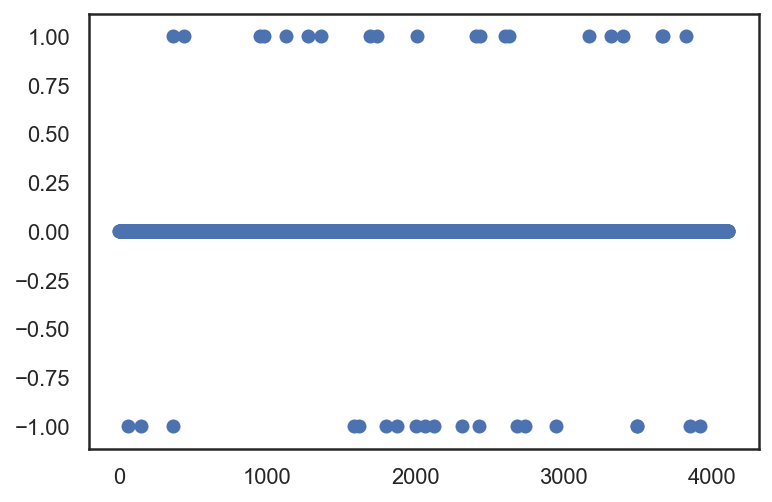

'\nneste mesmo gráfico, adicionar os resultados dos outros métodos com diferentes cores\n'

In [107]:
# plot decision tree
x_plot = list(range(len(y_test)))
y_pred = dtc.predict(X_test)

plt.scatter(x_plot, y_pred - y_test, label = 'pred')#, alpha = 0.5)
#plt.scatter(x_plot, y_test, label = 'test', alpha = 0.5)
#plt.legend()
plt.show()

# the ones where the model fails are the values in 1(y_pred higher than y_test) and -1 (the opposite)

### 6. Classification report

In [108]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3113
           1       0.96      1.00      0.98       999

    accuracy                           0.99      4112
   macro avg       0.98      0.99      0.99      4112
weighted avg       0.99      0.99      0.99      4112



### 7. ROC Evaluation

0.9872781551226781


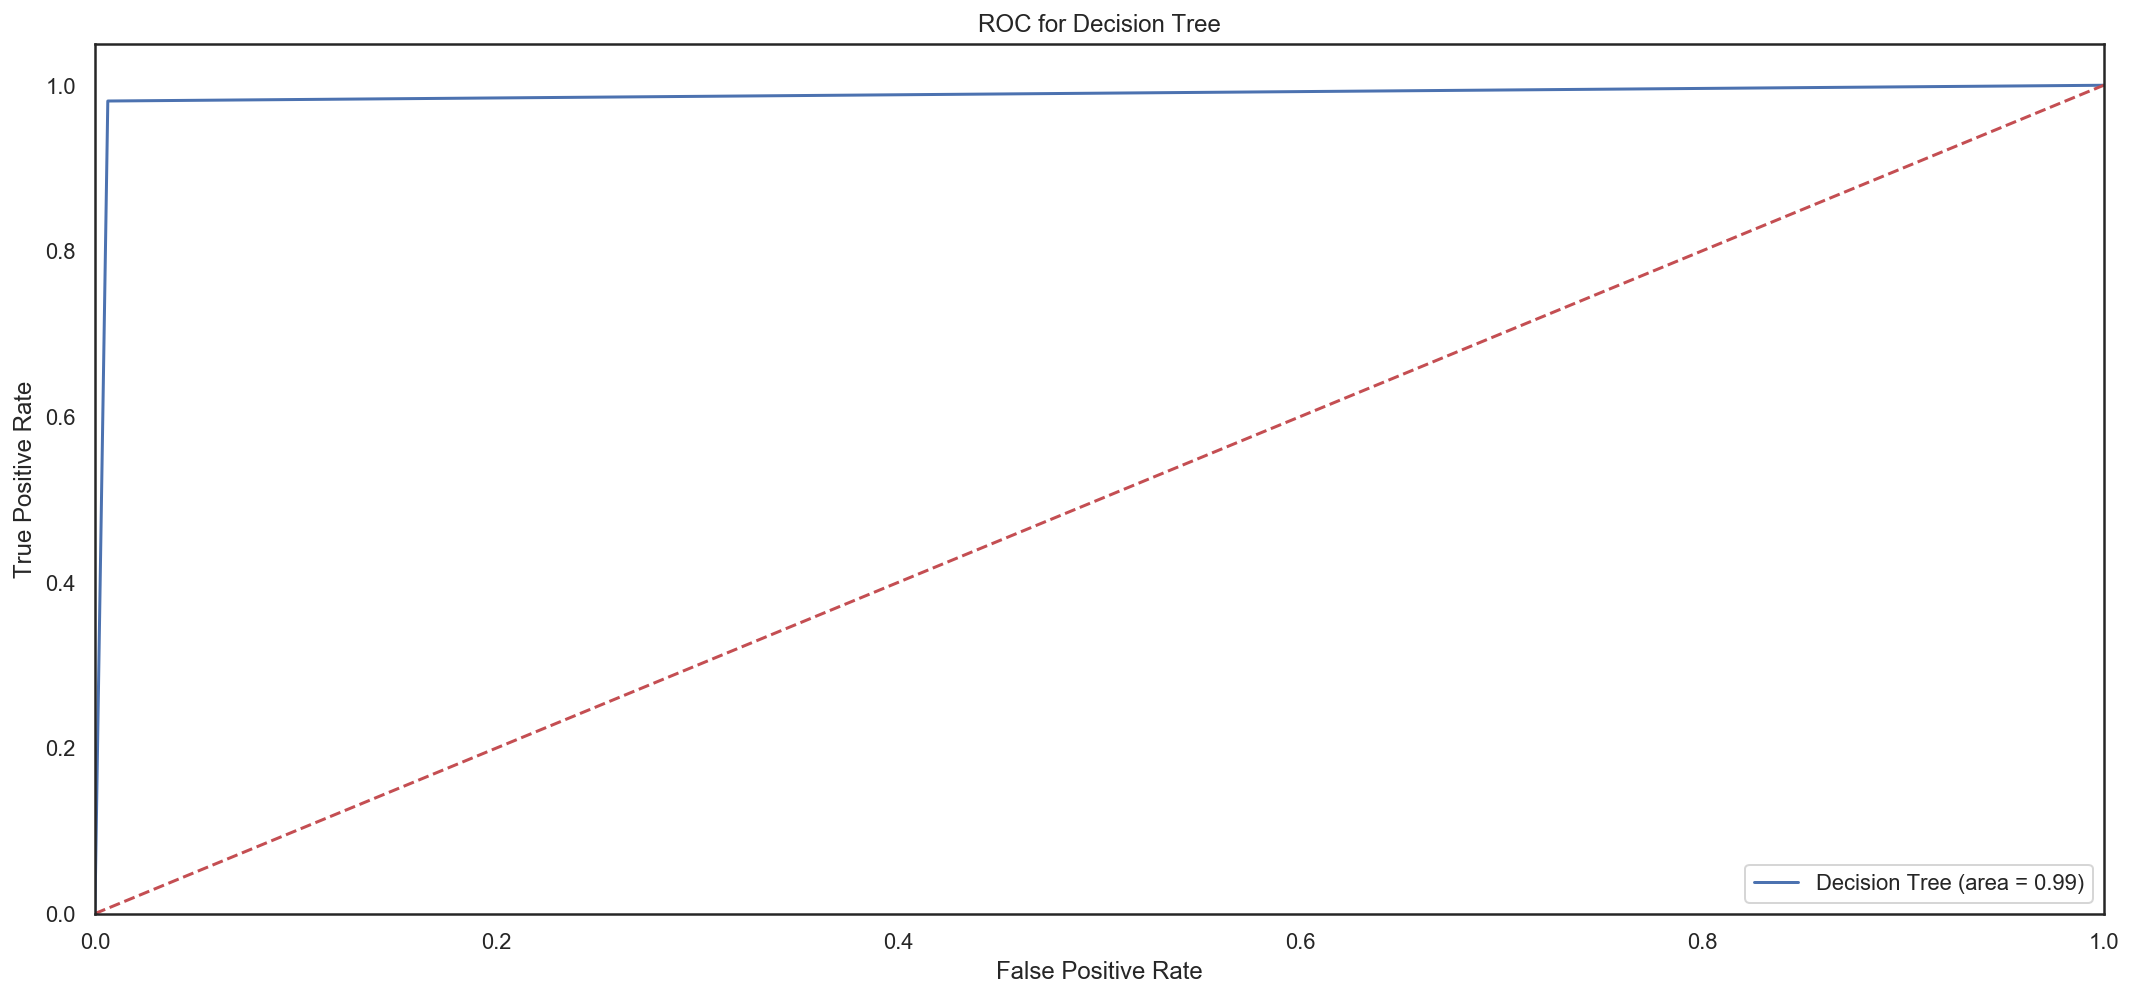

'\na good classifier stays as far away from the line as possibile\ntoward top-left corner is good\n'

In [279]:
# ROC score
from sklearn.metrics import roc_auc_score

dtc_roc_auc = roc_auc_score(y_test, y_pred_dtc)
print(dtc_roc_auc)

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, dtc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dtc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

A good classifier stays as far away from the line as possibile
toward top-left corner is good, so I'm good.

<a name="modeling-resampled-dataset"></a>

## Modeling, prediction and evaluation - Resampling the data

Since my data is imbalanced and that can bias the models, I downsampled the training dataset.
I resampled the training data and not the whole data set because, in my opinion, that's the one used to fit the model and for that is the most relevant to the models performance.
For testing, my model should be abble to work with both imbalanced and balanced data.

### 1. Downsample the training data

In [110]:
# resample the data
from sklearn.utils import resample

# concatenate our training data back together
X_concat = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
non_occupied = X_concat[X_concat['Occupancy']==0]
occupied = X_concat[X_concat['Occupancy']==1]

In [111]:
X_concat.head(1)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
7355,22.1,34.545,429.0,1495.0,0.005694,1


In [112]:
# check total value counts for the label column
y_train.value_counts()

0    12697
1     3751
Name: Occupancy, dtype: int64

In [113]:
# downsample non occupied sample
non_occupied_downsampled = resample(non_occupied,
                                replace = False, # sample without replacement
                                n_samples = len(occupied), # match minority n
                                random_state = 29) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([non_occupied_downsampled, occupied])

# checking counts
downsampled.Occupancy.value_counts()

1    3751
0    3751
Name: Occupancy, dtype: int64

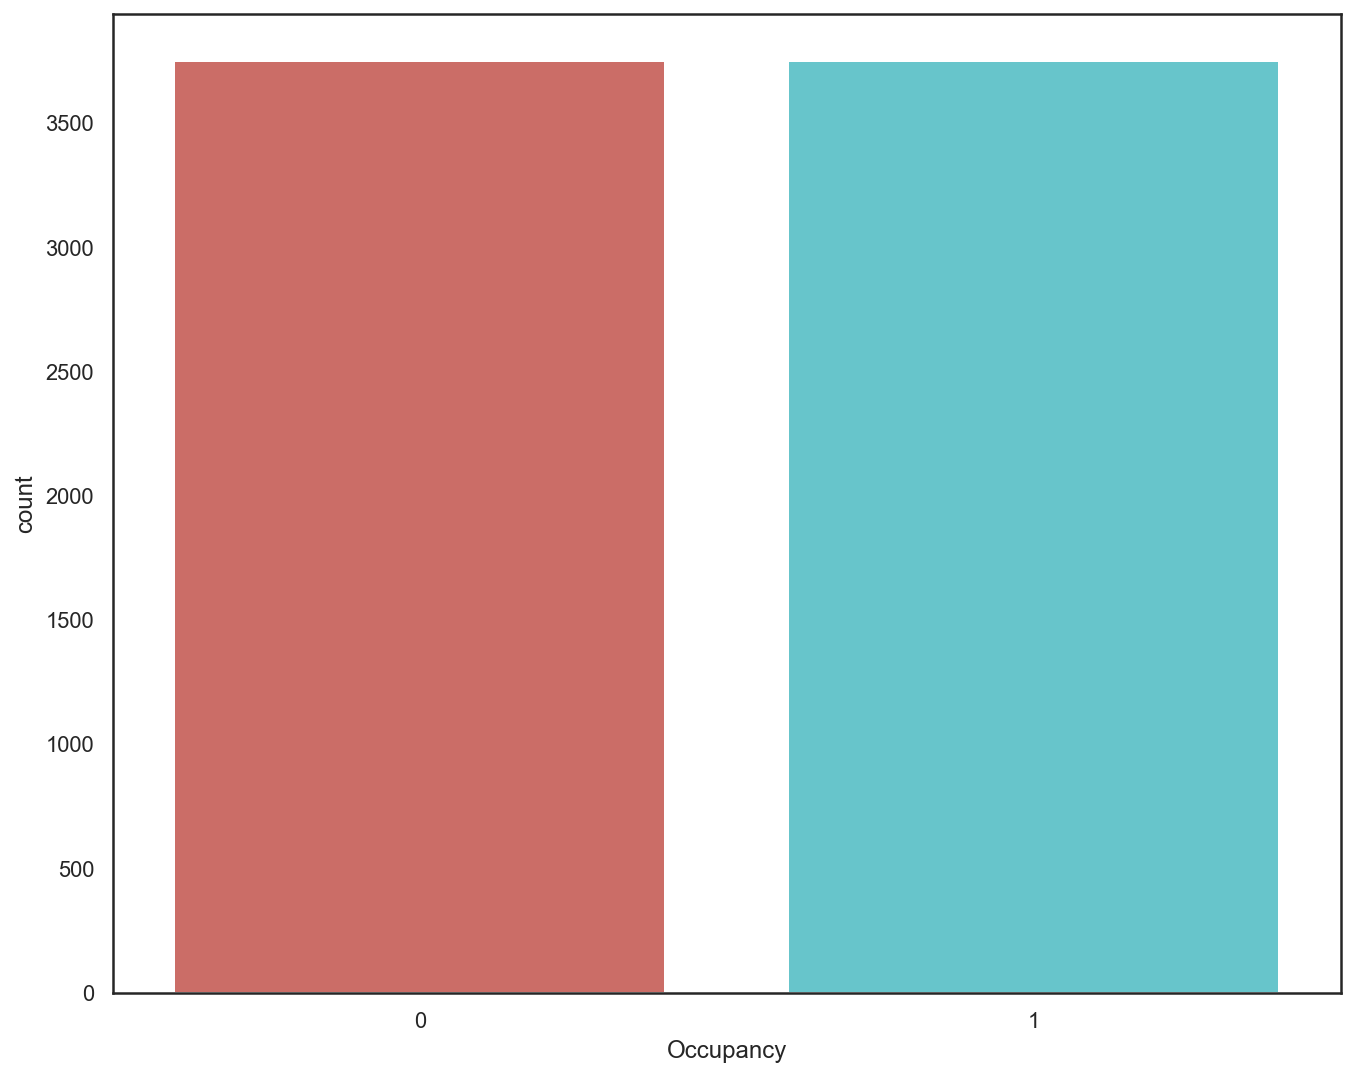

In [268]:
# plot labels histogram
f, ax = plt.subplots(figsize=(11,9))
sns.countplot(x= downsampled['Occupancy'], data=data_idx, palette='hls')
plt.show()

In [114]:
downsampled.head(1)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
14185,19.7,19.5,24.0,454.0,0.00276,0


In [115]:
# split the data
y_train_down = downsampled.Occupancy
X_train_down = downsampled.drop(['Occupancy'], axis=1)

### 2. Logistic regression again with the undersampled dataset

In [116]:
# initialize the model
lr_down = LogisticRegression()

# fit the model to the training data
lr_down.fit(X_train_down, y_train_down)

C:\Nane\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
# predict the response for the test dataset
y_pred_lr_down = lr_down.predict(X_test)

# accuracy score for training
acc_lr_down = lr_down.score(X_test,y_test) * 100

print(f"Logistic Regression Test Accuracy {round(acc_lr_down, 2)}%")

Logistic Regression Test Accuracy 98.83%


In [119]:
# print accuracy_score for the testing
accuracy_score(y_test, y_pred_lr_down)

0.9883268482490273

In [120]:
# create dictionary to compare the results of each model
acc_dict_down = {}

acc_dict_down['logistic regression'] = accuracy_score(y_test, y_pred_lr_down)

acc_dict_down

{'logistic regression': 0.9883268482490273}

### 3. Decision tree again with the undersampled dataset

In [123]:
# initialize the model
dtc_down = DecisionTreeClassifier()

# fit the model to the training data
dtc_down.fit(X_train_down, y_train_down)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [124]:
# accuracy score for training
acc_dtc_down = dtc_down.score(X_test, y_test) * 100

print(f"Decision Tree Test Accuracy {round(acc_dtc_down, 2)}%")

Decision Tree Test Accuracy 99.15%


In [125]:
# predict the response for the test dataset
y_pred_dtc_down = dtc_down.predict(X_test)

# create the confusion matrix
confusion_matrix(y_test, y_pred_dtc_down)

array([[3085,   28],
       [   7,  992]], dtype=int64)

Analyzing the results:
3085 + 992 correct predictions and 7 + 28 incorrect prediction

In [126]:
# print accuracy_score for the testing
accuracy_score(y_test, y_pred_dtc_down)

0.9914883268482491

In [127]:
# append results to acc_dict
acc_dict_down['decision tree'] = accuracy_score(y_test, y_pred_dtc_down)

In [128]:
sum(y_pred_dtc_down - y_test)

21

### 4. SVM again with the undersampled dataset

In [129]:
# initialize the model
svm_down = SVC()

# fit the model to the training data
svm_down.fit(X_train_down, y_train_down)

C:\Nane\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [130]:
# accuracy score for training
acc_SVC_down = svm_down.score(X_test, y_test) * 100

print(f"Support vector machine Test Accuracy {round(acc_SVC_down, 2)}%")

Support vector machine Test Accuracy 87.86%


In [131]:
# predict the response for the test dataset
y_pred_SVC_down = svm_down.predict(X_test)

# create the confusion matrix
confusion_matrix(y_test, y_pred_SVC_down)

array([[2617,  496],
       [   3,  996]], dtype=int64)

Analyzing the results:
2617 + 996 correct predictions and 3 + 496 incorrect prediction

In [132]:
# print accuracy_score for the testing
accuracy_score(y_test, y_pred_SVC_down)

0.878647859922179

In [133]:
# append results to acc_dict
acc_dict_down['support vector machine'] = accuracy_score(y_test, y_pred_SVC_down)

In [135]:
sum(y_pred_SVC_down - y_test)

493

### 5. KNN again with the undersampled dataset

In [136]:
# initialize the model
n_neigh = 2
knn_down = KNeighborsClassifier(n_neighbors = n_neigh)

# fit the model to the training data
knn_down.fit(X_train_down, y_train_down)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [137]:
# accuracy score for training
acc_KNN_down = knn_down.score(X_test, y_test)*100

print(f"KNN Test Accuracy {round(acc_KNN_down, 2)}%")

KNN Test Accuracy 98.74%


In [138]:
# predict the response for the test dataset
y_pred_KNN_down = knn_down.predict(X_test)

# create confusion matrix
confusion_matrix(y_test, y_pred_KNN_down)

array([[3083,   30],
       [  22,  977]], dtype=int64)

Analyzing the results:
3083 + 977 correct predictions and 22 + 30 incorrect prediction

In [139]:
# print accuracy_score for the testing
accuracy_score(y_test, y_pred_KNN_down)

0.9873540856031129

In [140]:
# append results to acc_dict
acc_dict_down['KNN'] = accuracy_score(y_test, y_pred_KNN_down)

In [141]:
sum(y_pred_KNN_down - y_test)

8

### 6. Compare accuracy and pick best model

In [142]:
# check the models perfomance
acc_dict_down

{'logistic regression': 0.9883268482490273,
 'decision tree': 0.9914883268482491,
 'support vector machine': 0.878647859922179,
 'KNN': 0.9873540856031129}

In [143]:
# pick method with higher accuracy
max(acc_dict_down, key = acc_dict_down.get)

'decision tree'

Decision tree still is the best model

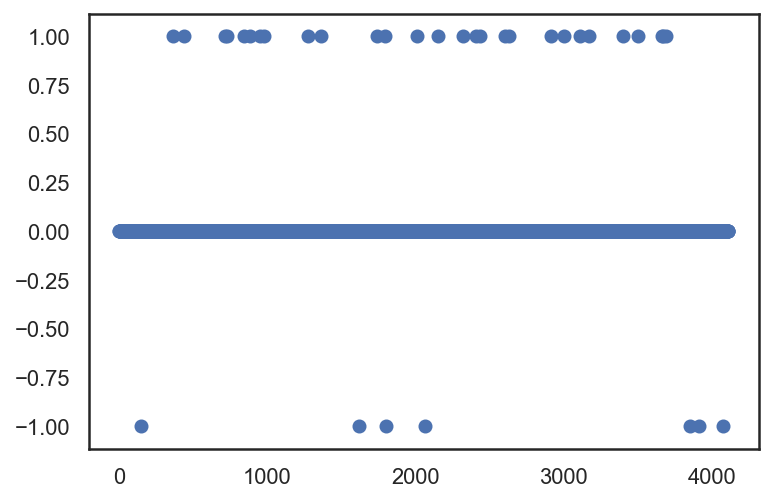

In [145]:
# plot decision tree
x_plot = list(range(len(y_test)))
y_pred_down = dtc_down.predict(X_test)

plt.scatter(x_plot, y_pred_down - y_test, label = 'pred')#, alpha = 0.5)
#plt.scatter(x_plot, y_test, label = 'test', alpha = 0.5)
#plt.legend()
plt.show()

# the ones where the model fails are the values in 1(y_pred higher than y_test) and -1 (the opposite)

In [152]:
list(acc_dict.values())

[0.9892996108949417, 0.9905155642023347, 0.954523346303502, 0.9832198443579766]

In [151]:
list(acc_dict_down.values())

[0.9883268482490273, 0.9914883268482491, 0.878647859922179, 0.9873540856031129]

In [168]:
# compare accuracy score results for imbalanced and balanced data
model_lst = list(acc_dict.keys())
acc_lst = list(acc_dict.values())
acc_down_lst = list(acc_dict_down.values())

acc_comp = [(model_lst[i],(acc_lst[i] - acc_down_lst[i])*100) for i in range(len(acc_lst))]
print(acc_comp)

[('logistic regression', 0.09727626459143934), ('decision tree', -0.09727626459143934), ('support vector machine', 7.5875486381323025), ('KNN', -0.4134241245136283)]


Observations after undersampling the train dataset:
- logistic regression and SVM have worst performance (specially SVM)
- Decision tree and KNN have better performances

<a name="RFE"></a>

## Recursive feature elimination

I used the recursive feature elimination to evaluate if all the features are necessary to make predict if the room is occupied or not.

In [170]:
# import RFE
from sklearn.feature_selection import RFE

In [190]:
# initialize the model using the decision tree model
estimator = dtc

n_features = 2

selector = RFE(estimator, n_features)

In [191]:
# fit the model
selector = selector.fit(X,y)

"\nSince the downsample didn't make a big difference, I used the whole data for \nthis analysis.\n"

In [192]:
# print the rating
print(selector.support_)
print(selector.ranking_)

[False False  True  True False]
[2 3 1 1 4]


In [182]:
X.head(1)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.7,26.272,585.2,749.2,0.004764


Feature importancce is ranked from most important (1) to least important (4)
most important:
- light
- CO2 concentration

Apply decision tree again for light and CO2 concentration only

In [193]:
# analyze reduced model

# generate model
X_reduced = X[['Light','CO2']]

# split the data
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced,y, train_size = 0.8, random_state = 29)

In [196]:
# initialize the model
dtc_reduced = DecisionTreeClassifier()

# fit the model
dtc_reduced.fit(X_train_reduced,y_train_reduced)

# compute the accuracy score for the model
y_pred_reduced = dtc_reduced.predict(X_train_reduced)

accuracy_score(y_train_reduced, y_pred_reduced) * 100

99.99392023346303

Apparently, these 2 variables are enough to predict the room occupancy
accuracy = 99.99%

<a name="CV"></a>

## Cross-Validation

In [212]:
from sklearn.model_selection import cross_val_score

cv = 5
scores = cross_val_score(dtc, X, y, cv=cv)
scores                                              

array([0.86113813, 0.97835603, 0.96011673, 0.75948444, 0.9584144 ])

In [213]:
# mean score and 95% confidence interval of the score
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.17)


In [214]:
'''
what now? how can I access the folder with lower accuracy?
'''

'\nwhat now? how can I access the folder with lower accuracy?\n'

In [215]:
X.shape[0]/5

4112.0

In [216]:
X.index

RangeIndex(start=0, stop=20560, step=1)

In [217]:
data_idx['Occupancy'][12336:16448].value_counts()

0    3526
1     586
Name: Occupancy, dtype: int64

In [220]:
data_idx['Occupancy'][4112:8224].value_counts()

0    3024
1    1088
Name: Occupancy, dtype: int64

In [229]:
step = int(X.shape[0]/cv)

for i in range(cv):
    start = step * i
    end = step * (i+1)
    positive = data_idx['Occupancy'][start:end].value_counts()[1]
    negative = data_idx['Occupancy'][start:end].value_counts()[0]
    print('fold:',(start,end),'score:',list(scores)[i],'ratio positive/negative:', positive/negative)

fold: (0, 4112) score: 0.8611381322957199 ratio positive/negative: 0.204099560761347
fold: (4112, 8224) score: 0.9783560311284046 ratio positive/negative: 0.35978835978835977
fold: (8224, 12336) score: 0.9601167315175098 ratio positive/negative: 0.4796689456639079
fold: (12336, 16448) score: 0.7594844357976653 ratio positive/negative: 0.16619398752127057
fold: (16448, 20560) score: 0.9584143968871596 ratio positive/negative: 0.3411611219830398


The lowest cross validation score matches the fold where there the ratio positives/negatives is lower which means that the model
has a better performance when predicting negative values. 

Also, higher cross validation score doesn't match higher positive/negative ration.

So my conclusion is that my model, although it was trained and fitted with balanced data - because I undersample the dataset,
performes better while predicting negatives than predicting positives.

Since I already downsampled the dataset, the way now is to get more positives data and train the model again with more data for both occupied and non-occupied instances.